In [1]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import corner
import corner
import time 
from scipy.stats import norm

In [2]:
# planet systems = Sys_{}_1e8.csv
def plot_hists( planet_systems,title=None):
    #try making more coherent plots
    ncol, nrow = 3,len(planet_systems)//3 +1
    #if len(planet_systems)%3 !=0:
    #    nrow+=1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    #axarr[0].histogram
    for jj , planet_sys in enumerate(planet_systems[:ncol*nrow]):
        #data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
        data=pd.read_csv("../../../Long300/" + planet_sys, index_col=0)
        #print planet_sys, data.shape

        data = data[data["t"]<1e8]
        data["logt"] = np.log10(data["t"])
        name = planet_sys.split("_")[1]
        # make guassian
        mean, sigma =  info[info["ID"]==int(name)][["Mean", "Sigma"]].values[0]

        x = np.linspace(mean - sigma*4, mean+sigma*4, 100)
        rv = norm(loc = mean, scale = sigma)
        axarr[jj//ncol, jj%ncol ].plot(x, rv.pdf(x), linewidth = 4, color = "black")
        #color = graph[-1].get_color()
        data.hist("logt",  ax = axarr[jj//ncol, jj%ncol],  label = name + " Mean - " +str("{0:.3f}".format(mean)) + " Sigma - "+ str("{0:.3f}".format(sigma)), alpha = 0.7, normed = 1, color = "purple", edgecolor = "black", bins = 20)
        #create gaussian on top 
        axarr[jj//ncol, jj%ncol ].set_title(name + r': $\mu$=' +str("{0:.3f}".format(mean)) + r': $\sigma$='+ str("{0:.3f}".format(sigma)))
    plt.show()
    if title == None:
        plt.close(fig)
    else:
        fig.savefig("../Figures/MCMCFigures/"+title, bbox_extent = "tight")
    #plt.close(fig)

In [3]:
np.random.seed(0)
#First let's create a gaussian data

#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
file_path = "../../../Long300/"
planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems

# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    except:
        probs = 0.00
    return probs
       
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    #print 
    return prob
                                    
print planet_systems.shape

(266,)


In [4]:
parameters = pd.read_csv("../../Figures/MCMCFigures/Weibull_Parameters_266.csv", index_col =0 )
parameters_t= parameters[parameters["Gamma"]>1]
parameters_t.shape

(236, 4)

In [6]:
#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"
#data.head()

nwalkers = 20
ndim = 2
iterations = 1000

#store all the mean and  sigma in one large array, and then plot it all at the very end,
#since there are 48 systems, and 20*1000 samples per system, the final data array will be 960 000 long.
sample_size = nwalkers*iterations*planet_systems.shape[0]
all_walker_samples=np.zeros((int(sample_size), 4)) # add an extra clumn for the system index, and one for iteration number in for loop 
#mean_samples = np.zeros()
values = np.zeros((planet_systems.shape[0], 7), dtype=str)
covariences = np.zeros((planet_systems.shape[0], ndim, ndim))

In [11]:
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error", "Determinant"])
info.head()

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv("../../../Long300/"+planet_sys, index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    #print data.shape
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[1]
    print sys_name

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    
    # Run 200 steps as a burn-in.
    #print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    print "Running MCMC ...",
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=jj)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
    #af = sampler.acceptance_fraction
    #print "Mean acceptance fraction:", np.mean(af)
    

    #Determine the best mean and sigma
    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)
    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]
    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )
    covarience = np.cov([mean_samples, sigma_samples])
    print covarience
    determinant = np.linalg.det(covarience)
    print determinant
    covariences[jj, :, :] = covarience
    '''
    ##PLOT SAMPLING SPACE
    fig = plt.figure(figsize=(15, 8))
    ax =fig.add_subplot("121")
    ax2 = fig.add_subplot("122")
    ax.hist(mean_samples, 100)
    ax.set_title("Samples for Mean - Optimal at " + str("{0:.4f}".format(mean_fit))+ " + "+ str("{0:.4f}".format(mean_std)))
    ax2.set_title("Samples for Sigma - Optimal at " + str("{0:.4f}".format(sigma_fit))+ " + "+ str("{0:.4f}".format(sigma_std)))
    ax2.hist(sigma_samples,  bins = np.linspace(np.min(np.abs(sigma_samples)), np.max(sigma_samples), 100))
    fig.suptitle("Parameters for System "+sys_name)
    #fig.savefig("../../MLstability/Figures/MCMCFigures/Parameters_"+sys_name, bbox_inches='tight')
    plt.close(fig)
    '''
    
    
    
    ##PLOT CORNER PLOT
    probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    '''
    print samples.shape
    fig = plt.figure(figsize=(12, 12))
    fig = corner.corner(samples, labels=["$m$", "$s$"],  figsize = (12, 12))
    fig.suptitle("MCMC fit for Mu and Sigma for System "+ sys_name + " with Probability of "+ str("{:.4f}".format(np.exp(probability))))
    #fig.savefig("../../MLstability/Figures/MCMCFigures/System_"+sys_name, bbox_inches='tight')
    plt.close(fig)
    '''
       
    #SAVE INFO OF INTEREST
    if np.exp(probability)>1:
        info.loc[jj] = [sys_name]+[np.inf]+[mean_fit, sigma_fit] + [np.inf]*3

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std, determinant]
    print sys_name , probability, np.exp(probability),"\n"
    

    #save all the wallker values to be plotted later on
    #the thrid column in the system name
    #the fourth column is giving an index number, used for creating the custom color bar
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers), :2] = samples[:,:]
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers):,2] = sys_name
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers):,3] = jj

    #break

1007
Running MCMC ... Done at ... 0.722801923752 seconds.
[[ 2.01689623e-04 -4.11001458e-06]
 [-4.11001458e-06  1.09223237e-04]]
2.2012301345066203e-08
1007 -2.0343349252547993 0.13076742370062153 

1021
Running MCMC ... Done at ... 0.713684082031 seconds.
[[1.11726181e-04 1.16410501e-06]
 [1.16410501e-06 5.58845223e-05]]
6.242409126663046e-09
1021 -1.6838867670865596 0.1856509897533758 

1025
Running MCMC ... Done at ... 0.715368032455 seconds.
[[ 1.53732718e-04 -1.71994910e-06]
 [-1.71994910e-06  7.38094212e-05]]
1.1343964750563798e-08
1025 -1.8644893844660064 0.15497532249217522 

1041
Running MCMC ... Done at ... 0.714594125748 seconds.
[[2.38672088e-04 5.09163013e-06]
 [5.09163013e-06 1.16322560e-04]]
2.7737023636056382e-08
1041 -2.0880393092867235 0.12392988593718939 

10518
Running MCMC ... Done at ... 0.729496955872 seconds.
[[1.92327695e-04 2.03493321e-06]
 [2.03493321e-06 9.23234610e-05]]
1.775221748310979e-08
10518 -1.9400533066654064 0.14369628960350553 

1052
Running MCMC 

/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in double_scalars


 Done at ... 0.56553196907 seconds.
[[inf nan]
 [nan inf]]
nan
99 -2.0316018001696095 0.13112531628647817 



In [5]:
#save data
#info.to_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_{0}.csv".format(info.shape[0]))

#FILTER DATA (between 1e4 and 1e7)
info = pd.read_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_266.csv", index_col=0)

#fully integrated data
short_feats = pd.read_csv("../../csvs/deltatimes.csv", index_col =0 )
subsystem = info["ID"].values.astype(int)
sub_short = short_feats.loc[subsystem]
print sub_short.shape

#filtered data params
filtered = sub_short[ (sub_short["t"]>1e4) & (sub_short["t"]<1e7) &
                    (sub_short["t_shadow"]>1e4 ) & (sub_short["t_shadow"]<1e7) ] 

print(filtered.shape)
filtered_inds = filtered.index
#df.loc[df['column_name'].isin(some_values)]
valid = info.loc[info["ID"].isin(filtered_inds)] 
valid.head()

(266, 3)
(248, 3)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08


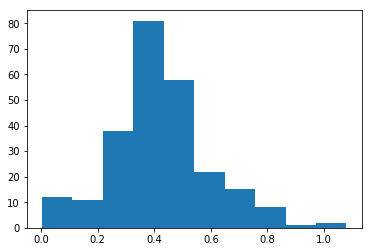

In [7]:
plt.hist(valid["Sigma"])
plt.show()

       ID  Probability      Mean     Sigma  Mean_Error  Sigma_Error  \
44   1356          inf  4.554517  0.060894         inf          inf   
45   1364          inf  4.704212  0.048453         inf          inf   
53   1424          inf  4.138757  0.043466         inf          inf   
57   1476          inf  4.343927  0.019483         inf          inf   
62   1508          inf  4.176141  0.003016         inf          inf   
68   1601     0.746261  4.453021  0.082194    0.002652     0.001774   
76   1640     0.600740  4.769929  0.099722    0.003197     0.002284   
104  1829          inf  5.132111  0.040220         inf          inf   
119  1886          inf  4.694606  0.020321         inf          inf   
132  1946          inf  5.122270  0.016139         inf          inf   
221  2364     0.654272  4.930846  0.090603    0.002979     0.002057   

      Determinant  
44            inf  
45            inf  
53            inf  
57            inf  
62            inf  
68   2.210781e-11  
76   5.

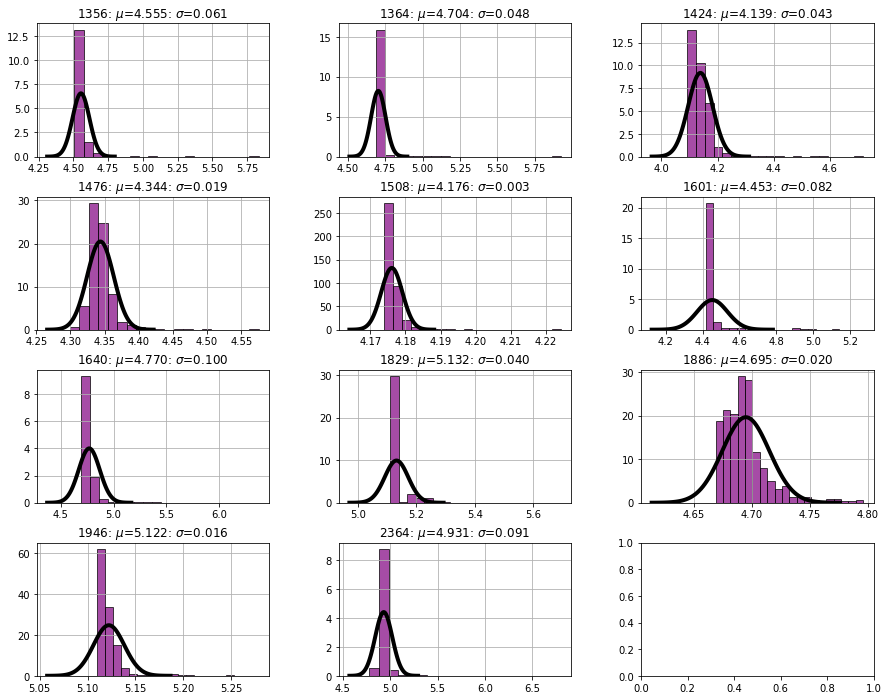

In [8]:
print valid[valid["Sigma"]<0.1] 
narrow = valid[valid["Sigma"]<0.1]["ID"]
narrow_ids = ["Sys_{0}_1e8.csv".format(x) for x in narrow]
plot_hists(narrow_ids)

       ID  Probability      Mean     Sigma  Mean_Error  Sigma_Error  \
12   1138     0.081776  6.156135  0.862268    0.027204     0.019868   
16   1194     0.081209  5.672191  0.915518    0.030957     0.021873   
42   1344     0.072535  5.512777  0.863578    0.027407     0.019371   
136  1971     0.077954  5.418235  0.826565    0.025957     0.019212   
175  2159     0.064933  5.176346  1.078939    0.033860     0.024384   
209  2299     0.070898  5.178627  0.861048    0.026690     0.019179   
248  3898     0.018218  5.458176  0.988571    0.024101     0.017273   

      Determinant  
12   2.921488e-07  
16   4.585387e-07  
42   2.816904e-07  
136  2.485958e-07  
175  6.817300e-07  
209  2.619408e-07  
248  1.733122e-07  


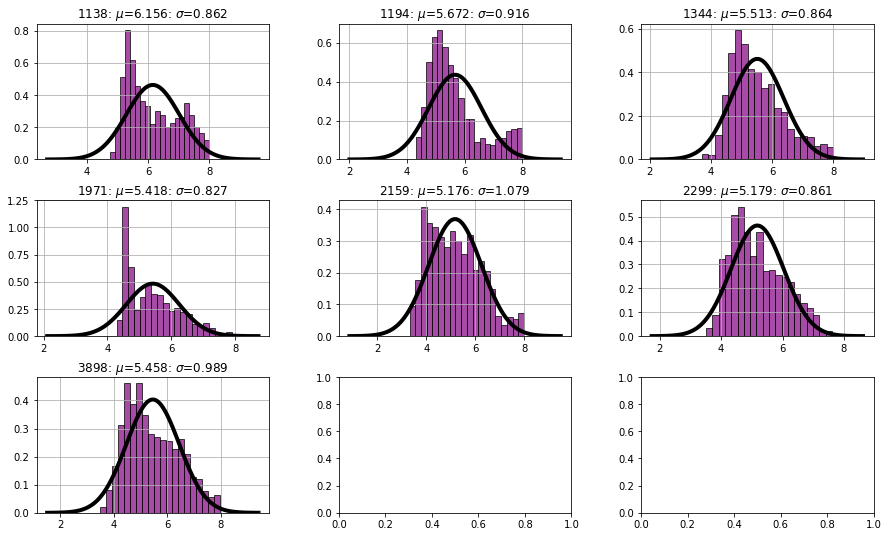

In [9]:
print valid[valid["Sigma"]>0.8]
wide = valid[valid["Sigma"]>0.8]["ID"]
wide_ids = ["Sys_{0}_1e8.csv".format(x) for x in wide]
plot_hists(wide_ids)

Need to do further tests on goodness of fits.
Try three

KS test

Shapiro-Wilk test (supposedely the best for testing for normality, but suffers from side effects of large sample sizes)

Anderson Darlignton test

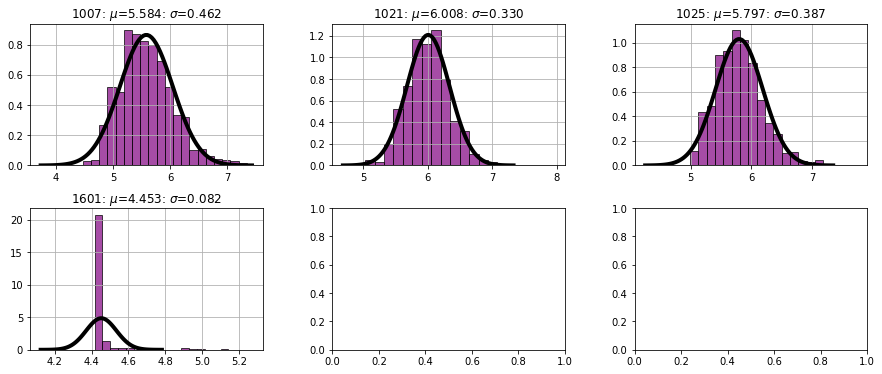

In [10]:
trials = ["Sys_{0}_1e8.csv".format(x) for x in [1007, 1021, 1025, 1601]]
plot_hists(trials)

In [11]:
from scipy.stats import anderson_ksamp, ks_2samp, shapiro
# the higher the test statistic, the better, 

anderson_ksamp_test

returns:	

statistic : float

    Normalized k-sample Anderson-Darling test statistic.
critical_values : array

    The critical values for significance levels 25%, 10%, 5%, 2.5%, 1%.
significance_level : float

    An approximate significance level at which the null hypothesis for the provided samples can be rejected.


In [28]:
#do tests for only valid systems within the instability time range cuts

planet_systems = ["Sys_{0}_1e8.csv".format(x) for x in valid["ID"] ]
sig_levels_and = np.zeros(len(planet_systems))
sig_levels_kstest = np.zeros(len(planet_systems))
sig_levels_shapiro = np.zeros(len(planet_systems))

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv("../../../Long300/"+planet_sys, index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    # id
    sys_name = planet_sys.split("_")[1]

    # normal we want to match
    test = np.random.normal(loc=valid.iloc[jj]["Mean"], scale=valid.iloc[jj]["Sigma"], size = data.shape[0])
    
    # anderson stats
    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except:
        statistic, crit_val, sig_level = 0,0,0
    print sys_name
    print "And",  statistic,  crit_val, sig_level
    sig_levels_and[jj] = sig_level
    # sig level should be as low as possible, means it is rejected at anything higher
    # An approximate significance level at which the null hypothesis for the provided samples can be rejected.
    
    #ks test
    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
    sig_levels_kstest[jj] = p_val
    print "KS", statistic, p_val#, 
    
    #shapiro   
    #data  = norm.rvs(loc=1, scale=1, size=100)
    try:
        statistic, p_val = shapiro(data)
    except:
        statistic, p_val = 0,0
    sig_levels_shapiro[jj] = p_val
    print "SH", statistic, p_val
    #https://stats.stackexchange.com/questions/15696/interpretation-of-shapiro-wilk-test
    #http://emilkirkegaard.dk/en/?p=4452
    #tldr
    #DO NOT DO SHAPIRO SCORE
    # sample size bias
    # Generally we see that given a large sample, SW is sensitive to departures from non-normality. If the departure is very small, however, it is not very important.
    # W value will be high until you try extremely non guassian distributions

    
    #p val should be as high? as possible, as that represents when to reject it
    #we cannot reject the null hypothesis at a 10% or
    #lower alpha since the p-value at 0.144 is higher than 10%
    #break
   

1007
And 0.604957265419835 [0.325 1.226 1.961 2.718 3.752] 0.187266258288
KS 0.044 0.28157331258093427
SH 0.976825833321 1.54737785085e-11
1021
And 1.2638295113848914 [0.325 1.226 1.961 2.718 3.752] 0.0973478504249
KS 0.050000000000000044 0.15955408974378718
SH 0.99047511816 4.49523258794e-06
1025
And 0.5973604059049219 [0.325 1.226 1.961 2.718 3.752] 0.18870840183
KS 0.035 0.5654378910227631
SH 0.973874509335 1.97653070126e-12
1041
And 14.406124713069746 [0.325 1.226 1.961 2.718 3.752] 2.05773057576e-05
KS 0.12060301507537685 8.813667689418526e-07
SH 0.917507231236 7.35683665382e-23
10518
And 8.070701440485776 [0.325 1.226 1.961 2.718 3.752] 0.000408500525484
KS 0.09667673716012087 0.0001678922663971905
SH 0.956124424934 1.15734717325e-16
1052
And 0.5142956628896067 [0.325 1.226 1.961 2.718 3.752] 0.205259427115
KS 0.040999999999999925 0.3631989538416812
SH 0.994273543358 0.000736115209293
1107
And 3.6135449059129843 [0.325 1.226 1.961 2.718 3.752] 0.0112899585217
KS 0.057000000000000

1.8780659940603558e+215
[1.87266258e-01 9.73478504e-02 1.88708402e-01 2.05773058e-05
 4.08500525e-04 2.05259427e-01 1.12899585e-02 6.10479814e-01
 4.55656727e-03 2.58374331e-02]
148 248
248


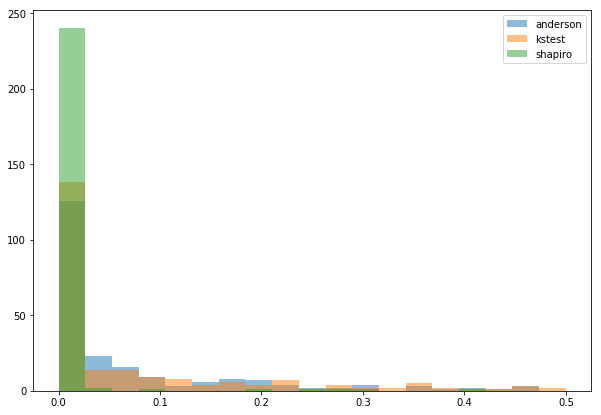

In [29]:
print sig_levels_and.max()
print sig_levels_and[:10]
# greater than one, since exptrapolations of large values will be inaccurate
# sig level means that it can be rejected at that significance level
# want this to be as low as possible
print len(np.where(sig_levels_and<0.05)[0]), len(sig_levels_and)
bins = np.linspace(0,0.5, 20)
plt.figure(figsize=(10, 7))
plt.hist(sig_levels_and, bins = bins, alpha = 0.5, label = "anderson")
#plt.show()
plt.hist(sig_levels_kstest, bins = bins, alpha = 0.5, label = "kstest")
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html
plt.hist(sig_levels_shapiro, bins = bins, alpha = 0.5, label = "shapiro")
#plt.show()
#plt.hist(sig_levels_shapiro)
plt.legend()
print len(np.where(sig_levels_shapiro<0.5)[0])
plt.show()

In [14]:
scores = np.vstack([ valid["ID"], sig_levels_and, sig_levels_kstest, sig_levels_shapiro])
print scores.shape
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P", "ShapiroW"] )
scores.head(20)

(4, 248)


,ID,Anderson_P,KS_P,ShapiroW
0,1007.0,0.187266,2.815733e-01,1.547378e-11
1,1021.0,0.097348,1.595541e-01,4.495233e-06
2,1025.0,0.188708,5.654379e-01,1.976531e-12
3,1041.0,0.000021,8.813668e-07,7.356837e-23
4,10518.0,0.000409,1.678923e-04,1.157347e-16
5,1052.0,0.205259,3.631990e-01,7.361152e-04
6,1107.0,0.011290,7.484708e-02,3.177200e-14
7,1120.0,0.610480,6.785104e-01,1.722353e-03
8,1124.0,0.004557,2.628441e-03,2.619127e-14
9,1128.0,0.025837,3.632700e-03,1.875177e-09


(98,)


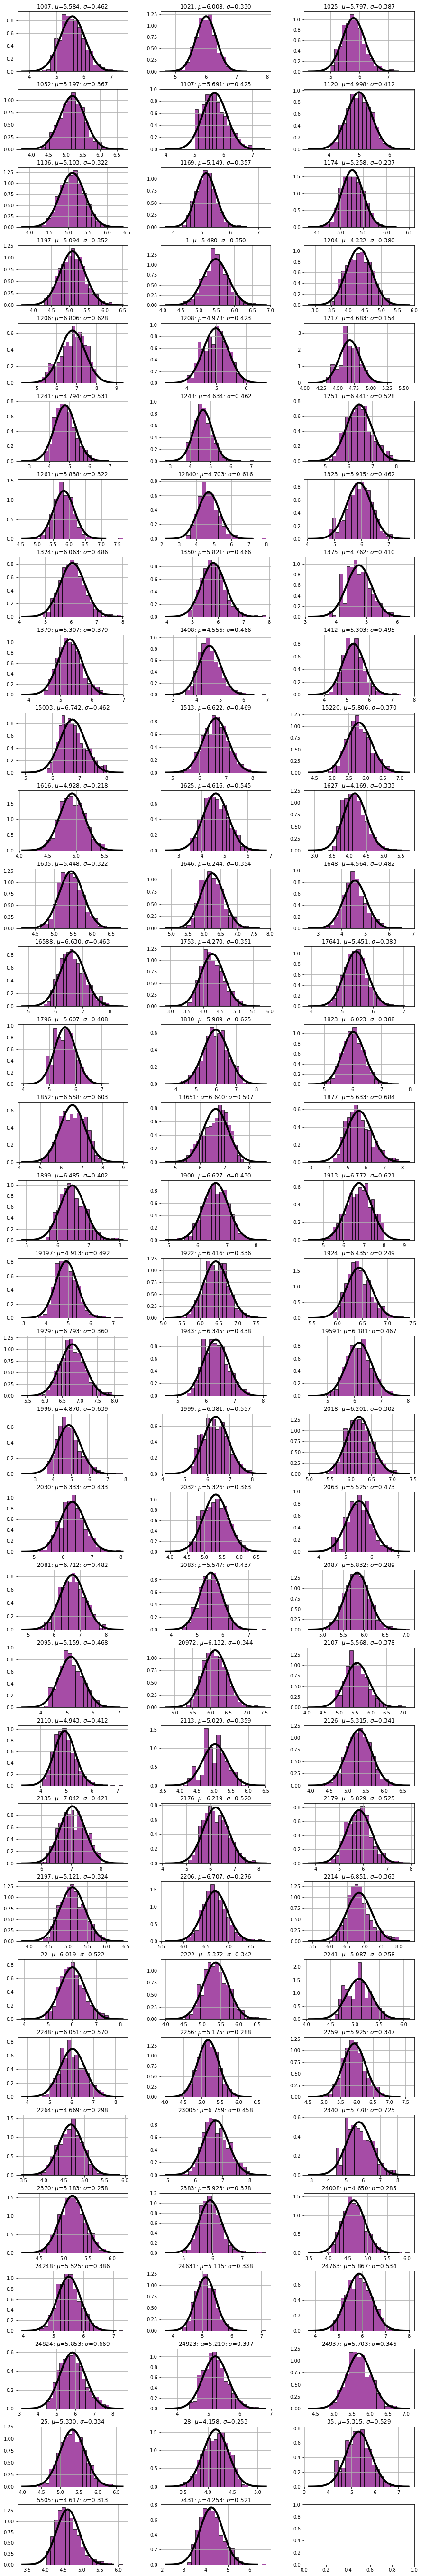

In [18]:
#look at cases where KS_P < 0.05, 5%, these should deviate significantly from normality
ks_rejects = scores[scores["KS_P"]>0.05]["ID"]
print ks_rejects.shape
ks_R = ["Sys_{0}_1e8.csv".format(int(x)) for x in ks_rejects]
plot_hists(ks_R)

(31,)


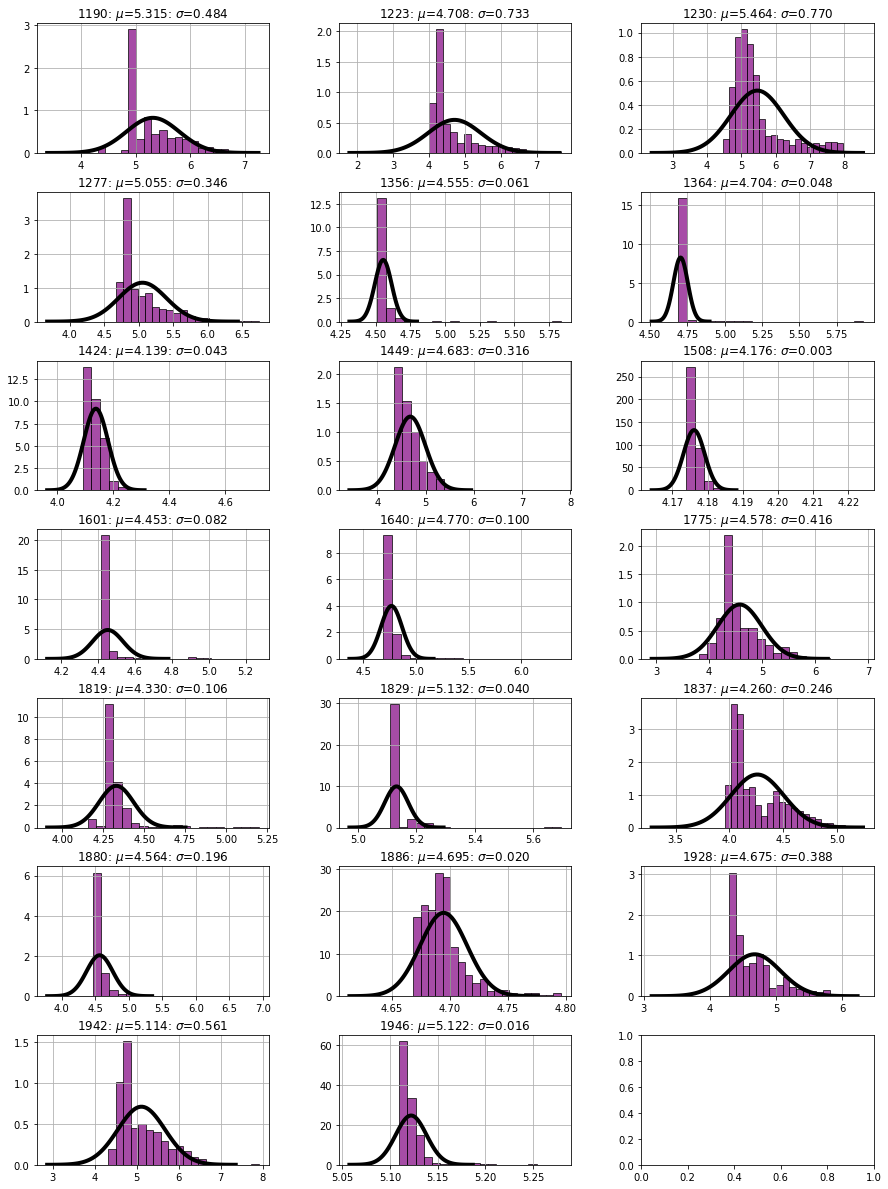

In [24]:
ks_rejects = scores[scores["KS_P"]<1e-10]["ID"]
print ks_rejects.shape
ks_R = ["Sys_{0}_1e8.csv".format(int(x)) for x in ks_rejects[:20]]
plot_hists(ks_R)

(59, 4)


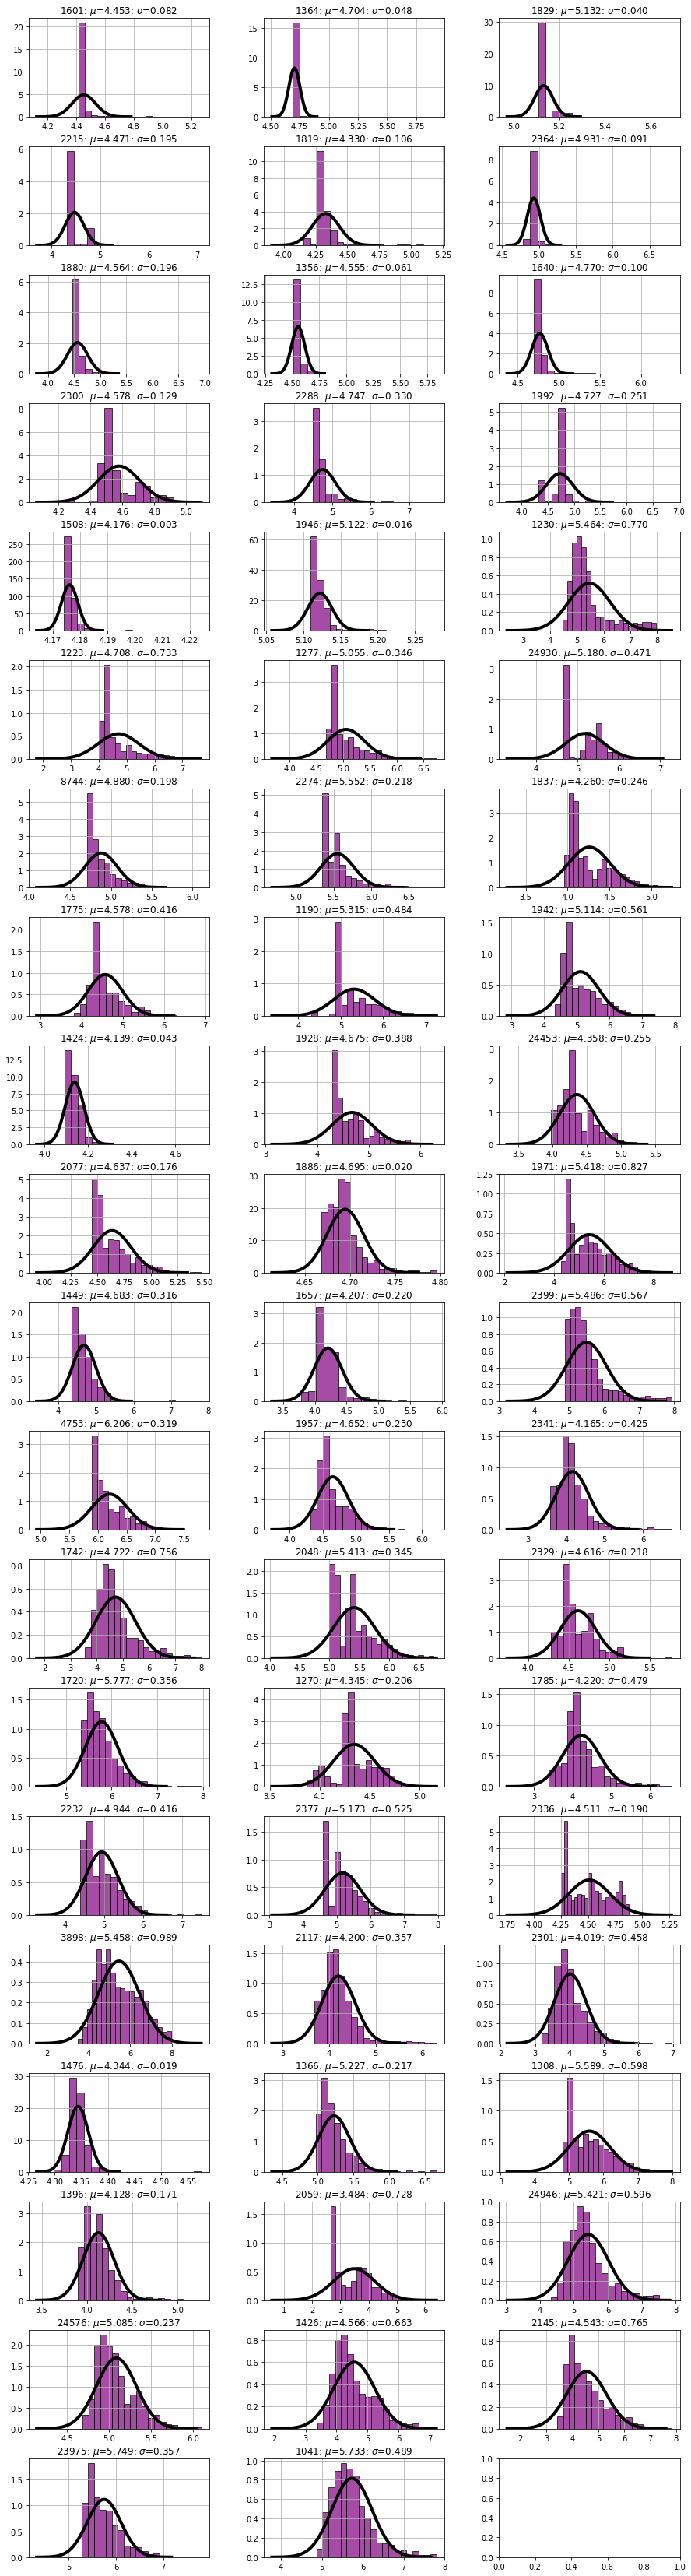

In [37]:
ks_rejects = scores[scores["KS_P"]<1e-6]

#use a higher threshold to see where to remove systems and order them from worst fit to best fit.
print ks_rejects.shape
sorted_scores = ks_rejects.sort_values(["KS_P"])
#print sorted_scores
ks_R = ["Sys_{0}_1e8.csv".format(int(x)) for x in ks_rejects["ID"]]
plot_hists(ks_R)

(6,)
Anderson_P
KS_P
ShapiroW


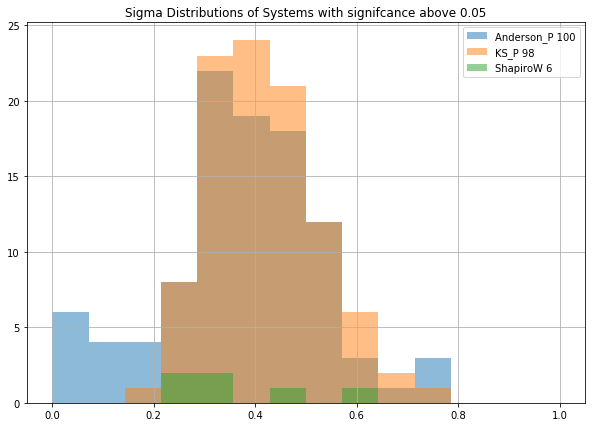

In [65]:
# plot distribution of sigmas with out the bad ~50 systems.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot("111")
#retained_sys = scores[scores["ShapiroW"]>5e-2]["ID"] # 5% sig level
print retained_sys.shape
bins = np.linspace(0,1,15) 
for val in scores.columns[1:]:
    print val
    retained_sys = scores[scores[val]>5e-2]["ID"] # 5% sig level
    cuts = info[ info["ID"].isin(retained_sys) ]
    cuts.hist("Sigma", ax = ax, label= val + " "+str(cuts.shape[0]) , alpha = 0.5, bins  = bins)
    #info[ info["ID"].isin(scores[scores["KS_P"]>5e-2]["ID"])].hist("Sigma", ax = ax, label = "KS", alpha = 0.5)
    #info[ info["ID"].isin(scores[scores["Anderson_P"]>5e-2]["ID"])].hist("Sigma", ax = ax, label = "Anderson", alpha = 0.5)
plt.legend()
plt.title("Sigma Distributions of Systems with signifcance above 0.05")
plt.show()

In [68]:
scores.to_csv("../../csvs/significance_scores.csv", index=0)
scores.head()


,ID,Anderson_P,KS_P,ShapiroW
67,1601.0,0.000000e+00,1.541904e-66,0.000000e+00
44,1364.0,1.878066e+215,7.464849e-62,0.000000e+00
102,1829.0,4.539668e+168,3.195230e-60,0.000000e+00
182,2215.0,8.177321e+84,2.970647e-59,2.242078e-44
99,1819.0,2.200495e+85,7.786949e-45,1.401298e-45


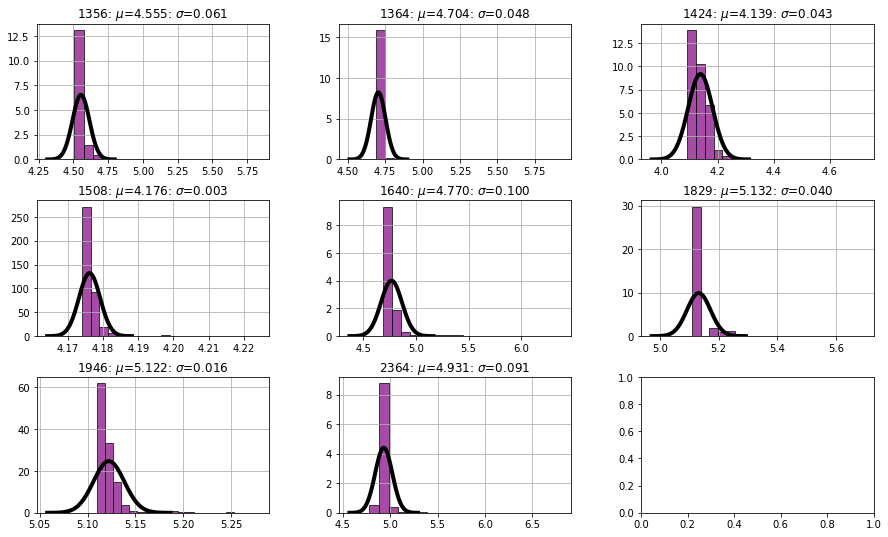

In [76]:
# seems like the anderson valid systems still has very low sigmas?
val = "Anderson_P"
retained_sys = scores[scores[val]>5e-2] # 5% sig level
retained_sys = retained_sys.sort_values(val)

cuts = info[ info["ID"].isin(retained_sys["ID"]) ]
small = cuts[cuts["Sigma"]<0.1]
cut_ids = ["Sys_{0}_1e8.csv".format(x) for x in small["ID"]]
plot_hists(cut_ids)

#least to hgihest p value, for sys with sigma less than 0.1

In [79]:
#check their scores
retained_sys[retained_sys["ID"].isinsmall["ID"]

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
44,1356,inf,4.554517,0.060894,inf,inf,inf
45,1364,inf,4.704212,0.048453,inf,inf,inf
53,1424,inf,4.138757,0.043466,inf,inf,inf
62,1508,inf,4.176141,0.003016,inf,inf,inf
76,1640,0.600740,4.769929,0.099722,0.003197,0.002284,5.333520e-11
104,1829,inf,5.132111,0.040220,inf,inf,inf
132,1946,inf,5.122270,0.016139,inf,inf,inf
221,2364,0.654272,4.930846,0.090603,0.002979,0.002057,3.745564e-11
